# 1. Data Identification and Collection

Video Presentation: https://www.youtube.com/watch?v=qdI1i-Fe8xk

### Data Sources 

| Source | Name   | Technique | 
|------|------|-----|
|Twitter | @Fugglet_tv| Spyder & Twitter API 
|YouTube| Fugglet |    YouTube Comment Scraper*


*Philip Klostermann (2015) YouTube Comment Scraper (Verison 1.0) [Source Code]. https://github.com/philbot9/youtube-comment-scraper

### Import Packages

In [204]:
import csv
import pandas as pd
import re

import nltk
# stopwords, FreqDist, word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from PIL import Image
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import gensim
from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim import corpora, models, similarities

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers import LdaVowpalWabbit, LdaMallet

from textblob import TextBlob

from IPython.display import Image

import pyLDAvis.gensim

### Import Tweets

In [183]:
df = pd.read_csv('data/fugglet_tweets.csv')
df.head()

,user,id,date,texts
0,Fugglet_tv,1.123760e+18,5/2/2019 1:19,Apologies for the terrible stream quality toda...
1,Fugglet_tv,1.123700e+18,5/1/2019 21:12,Rivals with Aculite live now https://t.co/gifX...
2,Fugglet_tv,1.121930e+18,4/26/2019 23:53,FuggLinks\n\n⚡ https://t.co/WWEL3CKzb3 \n⚡ h...
3,Fugglet_tv,1.121060e+18,4/24/2019 14:53,Checking out the new patch! https://t.co/gifXC...
4,Fugglet_tv,1.121060e+18,4/24/2019 14:17,@gtuckgaming https://t.co/C0hZaJ6Ze1


### Import YouTube Comments 

In [23]:
comments = []
openfile = open('data/comments/pubg_comments_only.csv', 'r', encoding='utf-8')
r = csv.reader(openfile)
for i in r:
# get the first column only (ignoring the second column)
    comments.append(i)    
openfile.close()

In [71]:
df_yt = pd.read_csv('data/comments/pubg_comments_only.csv', encoding='utf-8')
df_yt.head()

,comment
0,0:27 | Max parachute depth - Hold “S” at any s...
1,"Fuck him, he plays on pc"
2,"why not 150,000 tips n tricks"
3,Hello Everybody! I wanted to let you guys know...
4,"after half a month, still using these <3"


# 2. Business and Data Understanding 

### Data Description

- The data which will be analyzed in this report comes from 2 sources. 

- The first of these sources is the streamer's YouTube channel comments. The video from which these comments were taken was chosen because it is one of the most popular videos but also represents the interests of the core fan base. 

- The second data source is the streamer's Twitter account from which all Tweets were downloaded using Spyder and the Twitter API 



### Business Understanding 

- Streamers have captures a large and valuable market within the gaming industry. 
- These streamer's fans are typically loyal patrons and enable the streamers to make gaming videos full time through services such as Twitch and YouTube which monetize their productions. 
- The data generated around the streams and videos can be difficult for a streamer to process into meaningful information because of the sheer volume there is to sort through. 
- Automating the processing of this data can be incredibly valuable for streamers because they may be able to tailor their content to attract more and larger audiences. 

### Business Questions

1. How do the average sentiment of Tweets (largely from the streamer) compare to the average sentiment of YouTube comments(almost entirely from fan base)?

2. Do the streamer's tweets influence topics and sentiment of the fan base on YoutTube?

3. What differences are there between the YouTube and Twitter data?

4. What are common topics in the Tweets and YouTube comments?

5. Who are the most engaged users?

6. Are the most active users contributing positive or negative comments?


# 3. Data Cleaning and Text Preprocessing 

### Process and Clean Tweets 

In [184]:
df['texts'] = df.texts.str.lower()
df.head(2)

,user,id,date,texts
0,Fugglet_tv,1.123760e+18,5/2/2019 1:19,apologies for the terrible stream quality toda...
1,Fugglet_tv,1.123700e+18,5/1/2019 21:12,rivals with aculite live now https://t.co/gifx...


In [185]:
# find out original tweets & retweets
df['retweet'] = df.texts.str.startswith("rt")
df.head(2)

,user,id,date,texts,retweet
0,Fugglet_tv,1.123760e+18,5/2/2019 1:19,apologies for the terrible stream quality toda...,False
1,Fugglet_tv,1.123700e+18,5/1/2019 21:12,rivals with aculite live now https://t.co/gifx...,False


In [186]:
df['hashtags'] = df.texts.str.findall(r"(?<=#)\w+")
df.head(2)

,user,id,date,texts,retweet,hashtags
0,Fugglet_tv,1.123760e+18,5/2/2019 1:19,apologies for the terrible stream quality toda...,False,[]
1,Fugglet_tv,1.123700e+18,5/1/2019 21:12,rivals with aculite live now https://t.co/gifx...,False,[]


In [187]:
# create a column
df['mentions'] = df.texts.str.findall("(?<=@)\w+")
df.head(4)

<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<ipython-input-187-de8350d9e198>:2: DeprecationWarning: invalid escape sequence \w
  df['mentions'] = df.texts.str.findall("(?<=@)\w+")


,user,id,date,texts,retweet,hashtags,mentions
0,Fugglet_tv,1.123760e+18,5/2/2019 1:19,apologies for the terrible stream quality toda...,False,[],[]
1,Fugglet_tv,1.123700e+18,5/1/2019 21:12,rivals with aculite live now https://t.co/gifx...,False,[],[]
2,Fugglet_tv,1.121930e+18,4/26/2019 23:53,fugglinks\n\n⚡ https://t.co/wwel3ckzb3 \n⚡ h...,False,[],[]
3,Fugglet_tv,1.121060e+18,4/24/2019 14:53,checking out the new patch! https://t.co/gifxc...,False,[],[]


In [188]:
# count how many hashtags in each tweet
df['hashtag_count'] = df.texts.str.findall("(?<=#)\w+").str.len()
df.head(4)

<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<ipython-input-188-34d362331cb8>:2: DeprecationWarning: invalid escape sequence \w
  df['hashtag_count'] = df.texts.str.findall("(?<=#)\w+").str.len()


,user,id,date,texts,retweet,hashtags,mentions,hashtag_count
0,Fugglet_tv,1.123760e+18,5/2/2019 1:19,apologies for the terrible stream quality toda...,False,[],[],0
1,Fugglet_tv,1.123700e+18,5/1/2019 21:12,rivals with aculite live now https://t.co/gifx...,False,[],[],0
2,Fugglet_tv,1.121930e+18,4/26/2019 23:53,fugglinks\n\n⚡ https://t.co/wwel3ckzb3 \n⚡ h...,False,[],[],0
3,Fugglet_tv,1.121060e+18,4/24/2019 14:53,checking out the new patch! https://t.co/gifxc...,False,[],[],0


In [189]:
# count how many mentions in each tweet
df['mention_count'] = df.texts.str.findall("(?<=@)\w+").str.len()
df.head(4)

<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<ipython-input-189-b55002969e0f>:2: DeprecationWarning: invalid escape sequence \w
  df['mention_count'] = df.texts.str.findall("(?<=@)\w+").str.len()


,user,id,date,texts,retweet,hashtags,mentions,hashtag_count,mention_count
0,Fugglet_tv,1.123760e+18,5/2/2019 1:19,apologies for the terrible stream quality toda...,False,[],[],0,0
1,Fugglet_tv,1.123700e+18,5/1/2019 21:12,rivals with aculite live now https://t.co/gifx...,False,[],[],0,0
2,Fugglet_tv,1.121930e+18,4/26/2019 23:53,fugglinks\n\n⚡ https://t.co/wwel3ckzb3 \n⚡ h...,False,[],[],0,0
3,Fugglet_tv,1.121060e+18,4/24/2019 14:53,checking out the new patch! https://t.co/gifxc...,False,[],[],0,0


In [190]:
df['hashtags'] = df['hashtags'].apply(', '.join)
df.head()

,user,id,date,texts,retweet,hashtags,mentions,hashtag_count,mention_count
0,Fugglet_tv,1.123760e+18,5/2/2019 1:19,apologies for the terrible stream quality toda...,False,,[],0,0
1,Fugglet_tv,1.123700e+18,5/1/2019 21:12,rivals with aculite live now https://t.co/gifx...,False,,[],0,0
2,Fugglet_tv,1.121930e+18,4/26/2019 23:53,fugglinks\n\n⚡ https://t.co/wwel3ckzb3 \n⚡ h...,False,,[],0,0
3,Fugglet_tv,1.121060e+18,4/24/2019 14:53,checking out the new patch! https://t.co/gifxc...,False,,[],0,0
4,Fugglet_tv,1.121060e+18,4/24/2019 14:17,@gtuckgaming https://t.co/c0hzaj6ze1,False,,[gtuckgaming],0,1


In [191]:
df['mentions'] = df['mentions'].apply(', '.join)
df.head()

,user,id,date,texts,retweet,hashtags,mentions,hashtag_count,mention_count
0,Fugglet_tv,1.123760e+18,5/2/2019 1:19,apologies for the terrible stream quality toda...,False,,,0,0
1,Fugglet_tv,1.123700e+18,5/1/2019 21:12,rivals with aculite live now https://t.co/gifx...,False,,,0,0
2,Fugglet_tv,1.121930e+18,4/26/2019 23:53,fugglinks\n\n⚡ https://t.co/wwel3ckzb3 \n⚡ h...,False,,,0,0
3,Fugglet_tv,1.121060e+18,4/24/2019 14:53,checking out the new patch! https://t.co/gifxc...,False,,,0,0
4,Fugglet_tv,1.121060e+18,4/24/2019 14:17,@gtuckgaming https://t.co/c0hzaj6ze1,False,,gtuckgaming,0,1


In [192]:
df['cleaned'] = df['texts']
df.head(2)

,user,id,date,texts,retweet,hashtags,mentions,hashtag_count,mention_count,cleaned
0,Fugglet_tv,1.123760e+18,5/2/2019 1:19,apologies for the terrible stream quality toda...,False,,,0,0,apologies for the terrible stream quality toda...
1,Fugglet_tv,1.123700e+18,5/1/2019 21:12,rivals with aculite live now https://t.co/gifx...,False,,,0,0,rivals with aculite live now https://t.co/gifx...


In [193]:
df['cleaned'] = df.cleaned.str.replace('http\S+|www.\S+', '')
df['cleaned'] = df['cleaned'].str.replace("[^a-zA-Z]", " ")
df['cleaned'] = df.cleaned.str.findall('\w{3,}').str.join(' ')
df.head(2)

<>:1: DeprecationWarning: invalid escape sequence \S
<>:3: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \S
<>:3: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \S
<>:3: DeprecationWarning: invalid escape sequence \w
<ipython-input-193-4405c0f4246b>:1: DeprecationWarning: invalid escape sequence \S
  df['cleaned'] = df.cleaned.str.replace('http\S+|www.\S+', '')
<ipython-input-193-4405c0f4246b>:3: DeprecationWarning: invalid escape sequence \w
  df['cleaned'] = df.cleaned.str.findall('\w{3,}').str.join(' ')


,user,id,date,texts,retweet,hashtags,mentions,hashtag_count,mention_count,cleaned
0,Fugglet_tv,1.123760e+18,5/2/2019 1:19,apologies for the terrible stream quality toda...,False,,,0,0,apologies for the terrible stream quality toda...
1,Fugglet_tv,1.123700e+18,5/1/2019 21:12,rivals with aculite live now https://t.co/gifx...,False,,,0,0,rivals with aculite live now


### Process and Clean YouTube Comments 

In [38]:
# currently the data are in list ... convert to string
tokens = str(comments)
#lowecases
tokens = tokens.lower()
# Remove useless numbers and alphanumerical words
tokens = re.sub("[^a-zA-Z0-9]", " ", tokens)
#tokenization or word split
tokens = word_tokenize(tokens)
#Remove stopwords
tokens = (word for word in tokens if word not in stopwords.words('english'))
# Filter non-alphanumeric characters from tokens
tokens = (word for word in tokens if word.isalpha())
#remove short words
tokens = (word for word in tokens if len(word) >= 3)

In [75]:
df_yt['cleaned'] = df_yt.comment.str.lower()
df_yt.head(2)

,comment,cleaned
0,0:27 | max parachute depth - hold “s” at any s...,0:27 | max parachute depth - hold “s” at any s...
1,"fuck him, he plays on pc","fuck him, he plays on pc"


In [78]:
df_yt['cleaned'] = df_yt.cleaned.str.replace('http\S+|www.\S+', '')
df_yt['cleaned'] = df_yt['cleaned'].str.replace("[^a-zA-Z]", " ")
df_yt['cleaned'] = df_yt.cleaned.str.findall('\w{3,}').str.join(' ')
df.head(2)

,user,id,date,texts
0,Fugglet_tv,1.123760e+18,5/2/2019 1:19,Apologies for the terrible stream quality toda...
1,Fugglet_tv,1.123700e+18,5/1/2019 21:12,Rivals with Aculite live now https://t.co/gifX...


# 4. Descriptive Analytics 

### Twitter Descriptive Analytics

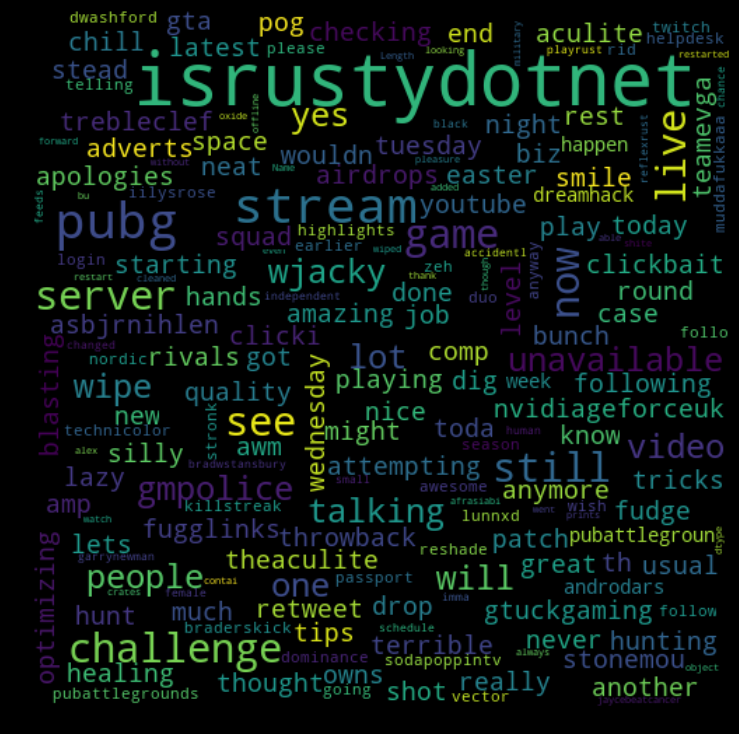

In [210]:
from wordcloud import WordCloud, STOPWORDS
# Convert dataframe to string
text = str(df['cleaned'])

# generate wordcloud
wordcloud = WordCloud().generate(text)
wordcloud = WordCloud(
    width = 500,
    height = 500,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))

fig = plt.figure(
    figsize = (10, 10),
    facecolor = 'k',
    edgecolor = 'k')

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [30]:
# using collections python library to count
from collections import Counter

fdist = list(Counter(" ".join(df['cleaned']).split(" ")).items())

# convert to dataframe
freq_word = []

for k,v in fdist:
    freq_word.append([k,v])

wordlist = pd.DataFrame(freq_word)

#
wordlist.sort_values(1, ascending=False).head(10)

,0,1
2,the,572
61,pubg,264
131,youtube,230
1,for,228
456,via,196
135,you,196
115,and,193
17,with,189
4,stream,182
19,live,178


### YouTube Descriptive Analytics 

In [39]:
#compute frequency distribution for all the bigrams in the text
fdist = nltk.FreqDist(tokens)

In [42]:
fdist.most_common(10)

[('ctrl', 117),
 ('video', 110),
 ('like', 88),
 ('game', 86),
 ('tires', 83),
 ('fugglet', 81),
 ('tips', 68),
 ('twice', 64),
 ('punch', 63),
 ('get', 60)]

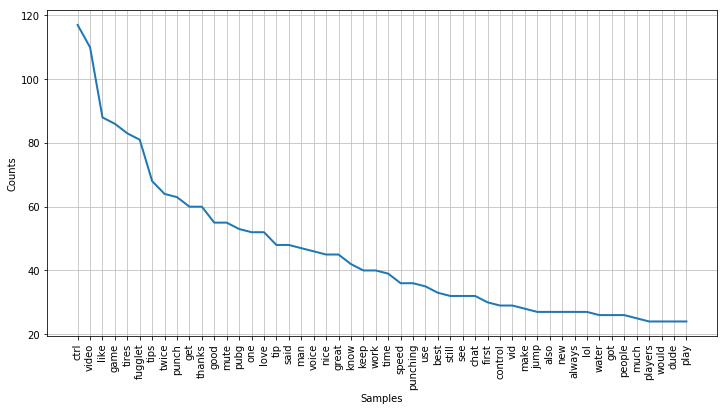

In [41]:
plt.figure(figsize=(12,6))
fdist.plot(50)

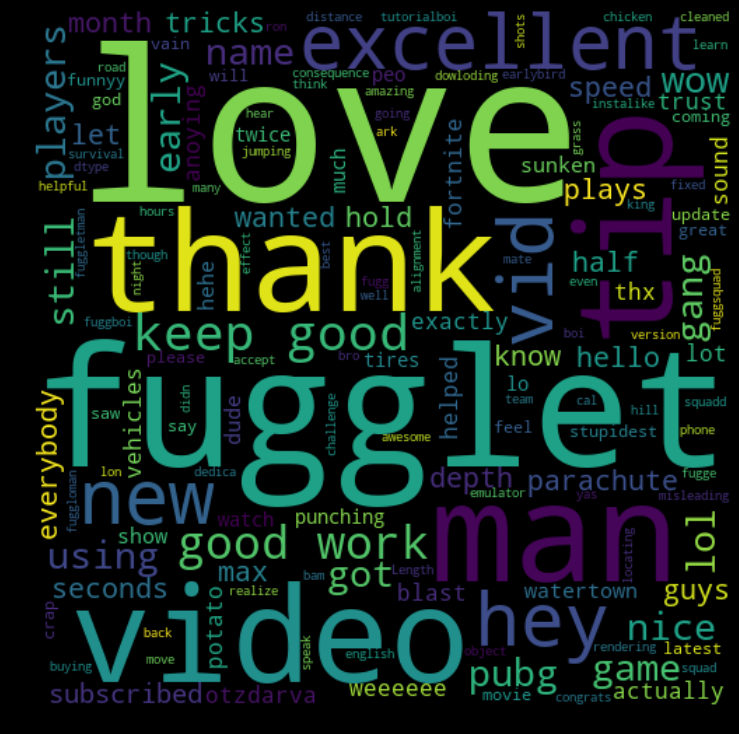

In [209]:
# Convert dataframe to string
#additional stopwrods
more_stopwords = set(('fuck', 'orgasm', 'damn'))

text = str(df_yt['cleaned'])

# generate wordcloud
wordcloud = WordCloud().generate(text)
wordcloud = WordCloud(
    width = 500,
    height = 500,
    background_color = 'black',
    stopwords = STOPWORDS | more_stopwords).generate(str(text))

fig = plt.figure(
    figsize = (10, 10),
    facecolor = 'k',
    edgecolor = 'k')

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# 5. Content Analysis 

### Twitter Topic Modeling

In [83]:
texts = []
r = csv.reader(open('data/fugglet_tweets.csv', 'r', encoding='utf-8'))
for i in r:
    texts.append(i)  
len(texts)

1672

In [84]:
# Remove useless numbers and alphanumerical words
documents = [re.sub("[^a-zA-Z]+", " ", str(text)) for text in texts]

# tokenize
texts = [ document.lower().split() for document in documents ]

# stemming words: having --> have; friends --> friend
lmtzr = WordNetLemmatizer()
texts = [ [lmtzr.lemmatize(word) for word in tokens] for tokens in texts]

#porter_stemmer = PorterStemmer()
#texts = [[porter_stemmer.stem(word) for word in text ] for text in texts]

# remove common words 
stoplist = stopwords.words('english')
texts =  [ [ word  for word in tokens if word not in stoplist]  for tokens in texts]

#remove short words
texts = [ [word for word in tokens if len(word) >=3 ] for tokens in texts]

In [85]:
## Create a dictionary representation of the documents.
dictionary = Dictionary(texts)
dictionary.save('data/fugglet_twitter.dict')  # store the dictionary, for future reference

len(dictionary)

3452

In [86]:
## Remove rare and common tokens.
# ignore words that appear in less than 5 documents or more than 50% documents (remove too frequent & infrequent words) - an optional step
dictionary.filter_extremes(no_below=5, no_above=0.5) #https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.filter_extremes
len(dictionary)

438

In [87]:
# convert words to vetors or integers
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('data/fugglet_tweets.mm', corpus)  # store to disk, for later use  # store to disk, for later use
len(corpus)

1672

In [88]:
print(('Number of unique tokens: %d' % len(dictionary)))
print(('Number of documents: %d' % len(corpus)))

Number of unique tokens: 438
Number of documents: 1672


In [107]:
# build a lda topic model (number of topics = 15, passes = 20, eval_every=1)
np.random.seed(1) # setting random seed to get the same results each time. 
model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=4, passes=30, eval_every=1)

In [108]:
model.show_topics(num_topics=4)
#show_topics(num_topics=10, num_words=10, log=False, formatted=True)

[(0,
  '0.060*"video" + 0.058*"stream" + 0.048*"new" + 0.033*"today" + 0.023*"hour" + 0.023*"tomorrow" + 0.017*"got" + 0.017*"one" + 0.016*"next" + 0.016*"day"'),
 (1,
  '0.039*"game" + 0.021*"time" + 0.019*"like" + 0.016*"get" + 0.015*"play" + 0.015*"custom" + 0.014*"know" + 0.014*"man" + 0.014*"video" + 0.013*"pubg"'),
 (2,
  '0.137*"pubg" + 0.135*"youtube" + 0.115*"via" + 0.031*"challenge" + 0.028*"fortnite" + 0.028*"airdrop" + 0.015*"new" + 0.015*"tip" + 0.014*"trick" + 0.012*"fuggman"'),
 (3,
  '0.161*"gifxchwscy" + 0.110*"live" + 0.036*"twitch" + 0.026*"let" + 0.021*"time" + 0.021*"get" + 0.014*"going" + 0.013*"broadcaster" + 0.011*"wjacky" + 0.011*"soon"')]

In [109]:
# print words without probability
for i in range(0,4):
    topics = model.show_topic(i, 10)
    print(', '.join([str(word[0]) for word in topics]))

video, stream, new, today, hour, tomorrow, got, one, next, day
game, time, like, get, play, custom, know, man, video, pubg
pubg, youtube, via, challenge, fortnite, airdrop, new, tip, trick, fuggman
gifxchwscy, live, twitch, let, time, get, going, broadcaster, wjacky, soon


In [110]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.096376 -0.192369       1        1  32.704891
1     -0.071559 -0.072155       2        1  25.490061
2      0.329695  0.038836       3        1  21.698301
3     -0.161760  0.225688       4        1  20.106741, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
9     Default  244.000000   gifxchwscy  244.000000  30.0000  30.0000
60    Default  220.000000      youtube  220.000000  29.0000  29.0000
29    Default  252.000000         pubg  252.000000  28.0000  28.0000
182   Default  187.000000          via  187.000000  27.0000  27.0000
10    Default  167.000000         live  167.000000  26.0000  26.0000
20    Default  176.000000        video  176.000000  25.0000  25.0000
13    Default  143.000000          new  143.000000  24.0000  24.0000
52    Default   56.000000       twitch   56.000000  23.0000  23.0000
6     Default  177.000000       stream  177.000000  22.0000  22.0000
8     Default   83.000000        today   83.000000  21.0000  21.0000
151   Default   46.000000     fortnite   46.000000  20.0000  20.0000
54    Default   46.000000      airdrop   46.000000  19.0000  19.0000
34    Default   40.000000          let   40.000000  18.0000  18.0000
17    Default   63.000000    challenge   63.000000  17.0000  17.0000
33    Default  104.000000         game  104.000000  16.0000  16.0000
242   Default   57.000000     tomorrow   57.000000  15.0000  15.0000
7     Default   73.000000         time   73.000000  14.0000  14.0000
273   Default   61.000000         hour   61.000000  13.0000  13.0000
45    Default   43.000000          got   43.000000  12.0000  12.0000
35    Default   29.000000         play   29.000000  11.0000  11.0000
153   Default   24.000000          tip   24.000000  10.0000  10.0000
80    Default   28.000000       custom   28.000000   9.0000   9.0000
124   Default   45.000000         like   45.000000   8.0000   8.0000
66    Default   27.000000         know   27.000000   7.0000   7.0000
140   Default   27.000000          man   27.000000   6.0000   6.0000
154   Default   23.000000        trick   23.000000   5.0000   5.0000
1     Default   76.000000          get   76.000000   4.0000   4.0000
214   Default   50.000000          one   50.000000   3.0000   3.0000
288   Default   20.000000  broadcaster   20.000000   2.0000   2.0000
311   Default   24.000000         rank   24.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
375    Topic4    4.887880       amount    5.619909   1.4646  -5.7292
148    Topic4    5.650653      totally    6.557567   1.4553  -5.5842
281    Topic4    7.972302          fps    9.363623   1.4433  -5.2400
347    Topic4    5.538759        tried    6.560157   1.4349  -5.6042
381    Topic4    7.627168          run    9.364299   1.3989  -5.2843
49     Topic4    7.467762      gifxcho    9.381218   1.3760  -5.3054
83     Topic4    8.104447          use   10.321788   1.3623  -5.2236
96     Topic4    6.571170         apex    8.445649   1.3532  -5.4333
301    Topic4    6.509149         help    8.446733   1.3435  -5.4428
353    Topic4    5.715135    snatching    7.510741   1.3309  -5.5729
219    Topic4    4.931150         real    6.558618   1.3189  -5.7204
299    Topic4    6.774600      denmark    9.396551   1.2770  -5.4028
71     Topic4   12.460934         come   18.811541   1.1922  -4.7934
62     Topic4   16.683201         soon   27.260113   1.1131  -4.5016
200    Topic4    9.032465       almost   13.115288   1.2312  -5.1152
7      Topic4   32.257748         time   73.675491   0.7782  -3.8422
103    Topic4   16.577793       royale   30.181170   1.0050  -4.5079
53     Topic4   16.906904       wjacky   31.108480   0.9944  -4.4883
1      Topic4   31.290815          get   76.349266   0.7121  -3.8727
180    Topic4   12.792764          sub   21.6

### YouTube Topic Modeling Analysis 

In [112]:
texts = []
r = csv.reader(open('data/comments/pubg_comments_only.csv', 'r', encoding='utf-8'))
for i in r:
    texts.append(i)  
len(texts)

1086

In [113]:
# Remove useless numbers and alphanumerical words
documents = [re.sub("[^a-zA-Z]+", " ", str(text)) for text in texts]

# tokenize
texts = [ document.lower().split() for document in documents ]

# stemming words: having --> have; friends --> friend
lmtzr = WordNetLemmatizer()
texts = [ [lmtzr.lemmatize(word) for word in tokens] for tokens in texts]

#porter_stemmer = PorterStemmer()
#texts = [[porter_stemmer.stem(word) for word in text ] for text in texts]

# remove common words 
stoplist = stopwords.words('english')
texts =  [ [ word  for word in tokens if word not in stoplist]  for tokens in texts]

#remove short words
texts = [ [word for word in tokens if len(word) >=3 ] for tokens in texts]

In [114]:
## Create a dictionary representation of the documents.
dictionary = Dictionary(texts)
dictionary.save('data/fugglet_twitter.dict')  # store the dictionary, for future reference

len(dictionary)

2161

In [115]:
## Remove rare and common tokens.
# ignore words that appear in less than 5 documents or more than 50% documents (remove too frequent & infrequent words) - an optional step
dictionary.filter_extremes(no_below=5, no_above=0.5) #https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.filter_extremes
len(dictionary)

348

In [116]:
# convert words to vetors or integers
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('data/pubg_comments_only.mm', corpus)  # store to disk, for later use  # store to disk, for later use
len(corpus)

1086

In [117]:
print(('Number of unique tokens: %d' % len(dictionary)))
print(('Number of documents: %d' % len(corpus)))

Number of unique tokens: 348
Number of documents: 1086


In [122]:
np.random.seed(1) # setting random seed to get the same results each time. 
model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=3, passes=30, eval_every=1)

In [123]:
model.show_topics(num_topics=3)
#show_topics(num_topics=10, num_words=10, log=False, formatted=True)

[(0,
  '0.051*"tip" + 0.048*"tire" + 0.041*"video" + 0.031*"twice" + 0.031*"punch" + 0.029*"thanks" + 0.024*"pubg" + 0.023*"said" + 0.021*"great" + 0.018*"punching"'),
 (1,
  '0.028*"love" + 0.027*"fugglet" + 0.026*"nice" + 0.022*"video" + 0.017*"work" + 0.016*"car" + 0.014*"challenge" + 0.014*"use" + 0.014*"keep" + 0.013*"water"'),
 (2,
  '0.056*"ctrl" + 0.035*"mute" + 0.034*"game" + 0.025*"get" + 0.022*"voice" + 0.020*"like" + 0.018*"player" + 0.016*"vehicle" + 0.016*"chat" + 0.015*"one"')]

In [124]:
# print words without probability
for i in range(0,3):
    topics = model.show_topic(i, 10)
    print(', '.join([str(word[0]) for word in topics]))

tip, tire, video, twice, punch, thanks, pubg, said, great, punching
love, fugglet, nice, video, work, car, challenge, use, keep, water
ctrl, mute, game, get, voice, like, player, vehicle, chat, one


In [125]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.219910  0.079372       1        1  33.754368
1     -0.027319 -0.198104       2        1  30.007961
2     -0.192592  0.118731       3        1  36.237671, topic_info=     Category        Freq       Term       Total  loglift  logprob
term                                                              
40    Default  113.000000       ctrl  113.000000  30.0000  30.0000
152   Default   94.000000       tire   94.000000  29.0000  29.0000
151   Default  107.000000        tip  107.000000  28.0000  28.0000
108   Default   71.000000       mute   71.000000  27.0000  27.0000
155   Default   59.000000      twice   59.000000  26.0000  26.0000
123   Default   59.000000      punch   59.000000  25.0000  25.0000
185   Default   55.000000     thanks   55.000000  24.0000  24.0000
194   Default   44.000000       nice   44.000000  23.0000  23.0000
188   Default   50.000000       love   50.000000  22.0000  22.0000
204   Default   44.000000       said   44.000000  21.0000  21.0000
163   Default   45.000000      voice   45.000000  20.0000  20.0000
244   Default   76.000000    fugglet   76.000000  19.0000  19.0000
183   Default   49.000000       pubg   49.000000  18.0000  18.0000
161   Default  121.000000      video  121.000000  17.0000  17.0000
203   Default   33.000000   punching   33.000000  16.0000  16.0000
229   Default   41.000000      great   41.000000  15.0000  15.0000
60    Default   58.000000        get   58.000000  14.0000  14.0000
120   Default   39.000000     player   39.000000  13.0000  13.0000
33    Default   32.000000       chat   32.000000  12.0000  12.0000
160   Default   32.000000    vehicle   32.000000  11.0000  11.0000
29    Default   26.000000        car   26.000000  10.0000  10.0000
59    Default   89.000000       game   89.000000   9.0000   9.0000
17    Default   30.000000       best   30.000000   8.0000   8.0000
345   Default   23.000000  challenge   23.000000   7.0000   7.0000
196   Default   27.000000        vid   27.000000   6.0000   6.0000
140   Default   26.000000      sound   26.000000   5.0000   5.0000
261   Default   21.000000        sub   21.000000   4.0000   4.0000
260   Default   20.000000   congrats   20.000000   3.0000   3.0000
167   Default   25.000000      water   25.000000   2.0000   2.0000
330   Default   22.000000     volume   22.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
56     Topic3   12.733027      flash   13.394485   0.9644  -5.0579
31     Topic3   20.924734     change   22.017551   0.9642  -4.5612
169    Topic3   12.713430     weapon   13.395055   0.9628  -5.0595
149    Topic3   12.679359       team   13.392183   0.9604  -5.0622
141    Topic3   11.733935      spawn   12.436915   0.9569  -5.1397
308    Topic3   10.814324    setting   11.477612   0.9555  -5.2213
120    Topic3   36.909615     player   39.260944   0.9533  -3.9937
53     Topic3   10.776962        far   11.476737   0.9522  -5.2247
77     Topic3    9.877683        hit   10.520742   0.9520  -5.3119
78     Topic3    9.865715    holding   10.520408   0.9508  -5.3131
61     Topic3   10.745900    getting   11.474799   0.9494  -5.2276
82     Topic3    9.852212     island   10.520679   0.9494  -5.3145
250    Topic3   12.526413        wow   13.392565   0.9482  -5.0743
344    Topic3   11.616054     muting   12.426856   0.9476  -5.1498
243    Topic3   10.723220   teammate   11.473715   0.9474  -5.2297
87     Topic3   15.950985        key   17.194439   0.9400  -4.8326
60     Topic3   50.560131        get   58.119541   0.8757  -3.6790
23     Topic3   10.706191       boat   11.478842   0.9454  -5.2313
59     Topic3   69.048706       game   89.394325   0.7568  -3.3673
38     Topic3   26.330763    control   31.353477   0.8405  -4.3314
6      Topic3   22.739079       also   26.627394   0.8572  -4.4781
70     Topic3   12.051532     helmet   13.395726   0.9093  -5.1130
11

### Twitter Sentiment Analysis (Textblob)

In [163]:
reviews = []
openfile = open('data/fugglet_tweets_only.csv', 'r', encoding='utf-8')
r = csv.reader(openfile)
for i in r:
    reviews.append(i)  
openfile.close()


In [164]:
#remove extra brackets
reviews = [x for y in reviews for x in y]
# Remove useless numbers and alphanumerical words
documents = [re.sub("[^a-zA-Z]+", " ", document) for document in reviews]
# tokenize
texts = [[word for word in document.lower().split() ] for document in documents]
# remove common words 
stoplist = stopwords.words('english')
texts = [[word for word in text if word not in stoplist] for text in texts]
#remove short words
texts = [[ word for word in tokens if len(word) >= 3 ] for tokens in texts]

#for row in documents:
 #   print(TextBlob(row).sentiment)

In [165]:
positive_review = []
negative_review = []
neutral_review = []

for row in reviews:
    #tweet = row[0]
    score = TextBlob(row).sentiment.polarity
    if score > 0:
        positive_review.append(row)
    elif score == 0:
        neutral_review.append(row)
    else:
        negative_review.append(row)

In [167]:
# Convert number of each review to string and print
num_pos = str(len(positive_review))
num_neg = str(len(negative_review))
num_neu = str(len(neutral_review))

print('Positive Tweets:' + num_pos)
print('Negative Tweets:' + num_neg)
print('Neutral Tweets:' + num_neu)

Positive Tweets:718
Negative Tweets:254
Neutral Tweets:700


### YouTube Sentiment Analysis (Textblob)

In [168]:
reviews = []
openfile = open('data/comments/pubg_comments_only.csv', 'r', encoding='utf-8')
r = csv.reader(openfile)
for i in r:
    reviews.append(i)  
openfile.close()


In [169]:
#remove extra brackets
reviews = [x for y in reviews for x in y]
# Remove useless numbers and alphanumerical words
documents = [re.sub("[^a-zA-Z]+", " ", document) for document in reviews]
# tokenize
texts = [[word for word in document.lower().split() ] for document in documents]
# remove common words 
stoplist = stopwords.words('english')
texts = [[word for word in text if word not in stoplist] for text in texts]
#remove short words
texts = [[ word for word in tokens if len(word) >= 3 ] for tokens in texts]

In [170]:
positive_review = []
negative_review = []
neutral_review = []

for row in reviews:
    score = TextBlob(row).sentiment.polarity
    if score > 0:
        positive_review.append(row)
    elif score == 0:
        neutral_review.append(row)
    else:
        negative_review.append(row)

In [172]:
# Convert number of each review to string and print
num_pos = str(len(positive_review))
num_neg = str(len(negative_review))
num_neu = str(len(neutral_review))

print('Positive Comments:' + num_pos)
print('Negative Comments:' + num_neg)
print('Neutral Comments:' + num_neu)

Positive Comments:490
Negative Comments:144
Neutral Comments:452


# 6. Network Analysis

In [203]:
# Create data set for network analysis
df_nw = pd.DataFrame()
df_nw['user1'] = df['user']
df_nw['user2'] = df['mentions']
df_nw.to_csv("data/fugglet_network.csv", index=False)

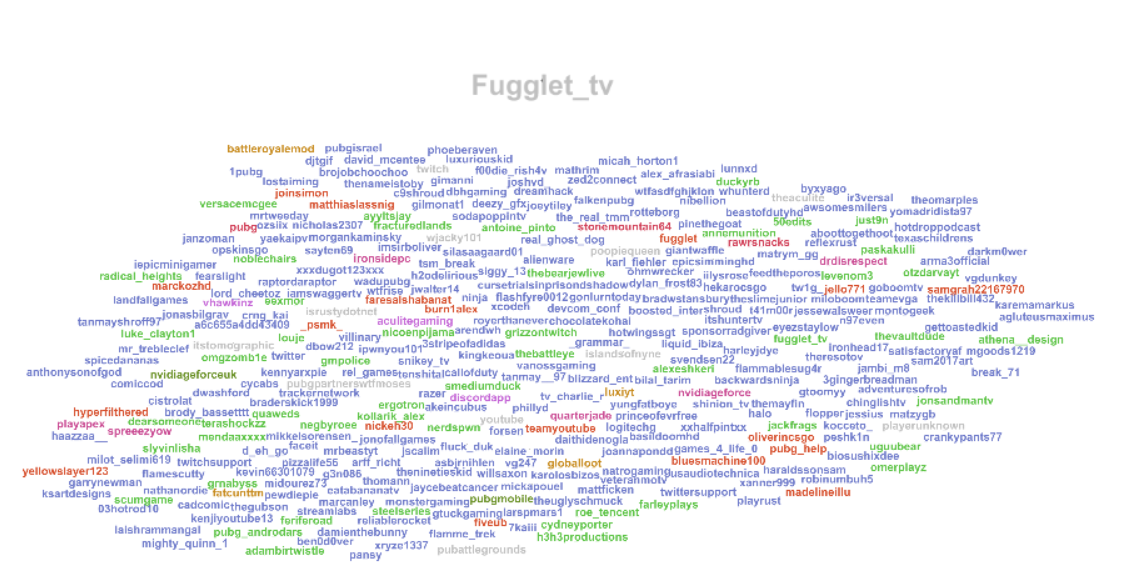

In [205]:
# Visualization of network 
Image("images/fugglet_network.png")

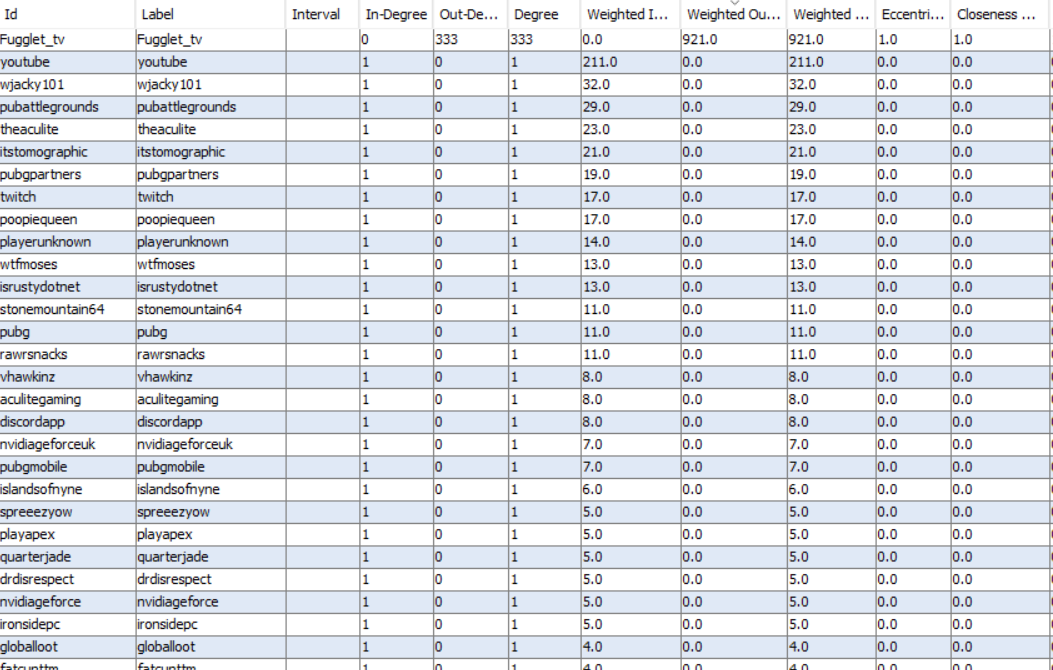

In [208]:
Image("images/fugglet_network_data.png")

### Conclusions from Network Analysis

- From this network analysis we can see that Fugglet interacts with a number of other Twitter accounts more frequently than others. 

- The accounts in blue and green are interacted with the least frequently.

- The accounts in gray, orange and red are the accounts that have the highest frequency of interactions. 

- The highest activity accounts are mainly the organizational accounts of sponsors, games and services which the streamer uses. As well as other streamers which frequently collaborate with Fugglet. 

- The nature of the data from Twitter means that we have visualized only the interactions between the streamer and accounts which he has retweeted or tweeted at. 

- The metrics of the network show that weighted degrees are the most useful because we are unable to map the second degree relationships and beyond. 

- Because the data represents the streamer's interactions with other accounts the edges were hidden in order to more easily view the names of the accounts which he interacted with. 


# 7. Final Analysis

## 7.1 - Descriptive Analytics

Twitter - @Fugglet_tv 

- The patterns in these tweets show a very professionally oriented account which mainly acts as a method for promoting content and interacting with sponsors. 
- It seems as if fans of Fugglet's productions are not interacting with his twitter account, or are not being retweeted often. 
- There are clear patterns in the releases of content as the word "Tuesday" and "Wednesday" are often seen in the tweets. 
- Some of the most frequent businesses interacted with on his twitter are European branches of global companies or are European organizations themselves. 
- European companies are more likely to interact with Fugglet as he is currently based out of Denmark. 


YouTube - "100 Tips and Tricks - Learn Everything | PUBG" - Fugglet 

- The wordcloud representing the YouTube comments show overwhelmingly positive themes.
- It appears that Fugglet's fan base is very interested in becoming better at the game PUBG as this video is one of the most viewed on the channel as well as having a large number of appreciative comments. 
- From the frequency analysis we can see the word "ctrl" appears the most frequently. This may be an indicator that people in the comments are expanding on some of the ideas shared in the video in regards to keyboard bindings. 
- Other popular words also show the community is engaged with the contents of the video rather than commenting off topic. 
- The engagement with the video shows that the fan base is a tight knit online community that interacts with each other as well as with the content creator. This is a valuable asset to the growth of a brand because it includes the fans and will allow them to expand organically. 

## 7.2 Content Analytics

Twitter - @Fugglet_tv
- The content from Fugglet's twitter account show that he primarily uses Twitter as a method for announcing new content as well as making plans with the fan base.
- The most common theme is that he announces when he will be hosting live streams.
- The ability to reach out to fans via multiple avenues is a valuable tool which can increase engagement.
- It would appear that his Twitter account also mentions 2 very popular game frequently: PUBG and Fortnite.
- These are two of the most popular battle royale games on the market at the moment and show that he is reaching large audiences in both games.
- The mentions of terms related to PUBG is significantly higher than those of Fortnite, suggesting that he caters to a more dedicated fan base rather than the larger one. 

- In terms of the sentiment of Fugglet's tweets we can see that he maintains a positive personality which is backed up by overwhelmingly positive tweets (42.9% positive tweets).
- There are only 254 negative tweets (15.2%) associated with his account which is a small portion of the 1600 tweets analyzed. 
- The negative tweets can most likely be attributed to technical issues experienced in games.
- The other majority of his tweets are neutral in sentiment, this makes sense as his twitter is primarily a source of information.

YouTube - 100 Tips and Tricks - Learn Everything | PUBG - Fugglet

- The content analysis of YouTube comments shows that many of the comments are praising Fugglet for the video and other videos. 
- This again shows us that he has created a loyal following on YouTube which is a powerful tool for streamers such as himself. 
- There are also indicators in the YouTube comments' content that tell us people are engaged in the content heavily.
- This engagement in the content can be categorized in 3 areas: 
    1. Comments related to the content of this video in particular 
    2. Comments related to other popular videos about PUBG on his channel 
    3. People praising Fugglet for this video 
- The sentiment of the comments on this video are: 
    1. 45.12% Positive 
    2. 13.26% Negative
    3. 41.62% Neutral 
- This distribution shows us that most people commenting are liking the content. 
- The nature of internet comments is typically negative and toxic, so it is impressive that this video garnered the support that it has. 

## 7.3 Network Analytics 

Twitter - @Fugglet_tv 
- The analysis of Fugglet's twitter account shows the most valuable relationships he has built in his community. 
- Some of the most valuable relationships are between Fugglet and the Player Unknown Battlegrounds game and Nvidia.
- These two organizations are very prominent in the gaming industry and have launched players and streamers into popularity through sponsorship of individuals and tournaments. 
- Other notable relationships include YouTube, Twitch and Discord. All of which are tools for streamers to connect with fans and grow their popularity. 
- These relationships also highlight some of the potential areas for growth. 
- If the streamer is able to foster the growth of his twitter presence, relationships with sponsors could be seen as more valuable to them. 
- Engagement with fans on twitter appears to be low as majority of interactions are broadcast rather than targeted.
- It would be potentially valuable for Fugglet to pursue methods to grow community engagement on Twitter. 